<a href="https://colab.research.google.com/github/neuralnetworksrs/Tarea-2/blob/master/Parte_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="bonus"></a>
## 0+. Bonus: Predicción de Ventas en Falabella
---

El problema de esta sección es muy similar al problema 4 de la tarea anterior y les permitirá corregir o entrenarse mejor en aquello que no hayan aprendido bien antes. Esta vez trabajaremos con series de datos reales correspondientes a las ventas de una conocida empresa nacional de retail (Falabella). Los datos fueron recolectados, pre-procesados y anonimizados por una tesista de esta universidad, a través del siguiente __[link](https://www.dropbox.com/sh/14or2wjdb3hp45l/AAAFx325iQ1OlLHacFB3sCh4a?dl=0)__.

<img src="https://www.modaes.com/files//000_2016/falabella/falabella-entrada-exterior-parque-arauco-728.jpg" width="50%" />



Grosso modo, la tarea consiste en anticipar las ventas de los diferentes productos de la compañía con al menos 1 mes de anticipación, es decir predecir hacia "adelante" desde al menos 1 mes. Para simplificar, nos concentraremos en solo **una** de las múltiples tiendas existentes y trataremos de predecir 4 productos de los 400.000 que maneja la empresa. Sin embargo, dispondremos de las series de ventas de todos los 400.000 productos para usar como predictores. Los datos disponibles cubren un horizonte de dos años y tienen frecuencia diaria, es decir, las series tiene un largo total de aproximadamente 2*350 = 700 valores. 

El formato del archivo de datos viene descrito en el archivo *README*. Cada fila corresponde a un día. En cada fila/día se representan las ventas de cada producto. Los productos no vendidos (venta=0) no aparecen.

Como metadata adicional (a usar de modo completamente libre y voluntario), se tiene: un árbol que indica las categorías a las que pertenecen los 400.000 productos (por ejemplo: “zapatos-mujer”), las categorías a las que pertenecen estas categorías (por ejemplo “zapatos”), las categorías a las que pertenecen estas categorías (por ejemplo “moda”) y así sucesivamente. También se tiene un diccionario, que relaciona los ID de producto con marca y otras características. 

Esta actividad es completamente libre, sin código de ayuda, que sin embargo puede reciclar de la tarea anterior. 

In [0]:
#csv desde drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq as hq
from keras import backend as K

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, GRU, Dropout, RepeatVector, CuDNNGRU, Conv1D, Flatten, SimpleRNN, BatchNormalization
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error
import math

#Función para categorizar los cyber days.

In [0]:
month_without_31_days = [1, 3, 5, 6, 7, 9]

def calculate_date(day, month, year):
    day += 1
    if day == 29 and month == 2:
          day = 1
          month += 1
    elif day == 31 and month == 12:
          day = 1
          month = 1
          year += 1
    elif day == 31 and month not in month_without_31_days:
          day = 1
          month += 1
    elif day == 31:
          day = 1
          month += 1

    return [day, month, year]
  
def cyber_day(day, month, year):
    if year == 2017:
        if month == 5:
            if day in [29, 30, 31]:
                return 1
        if month == 11:
            if day in [6, 7, 8]:
                return 1
    if year == 2018:
        if month == 5:
            if day in [28, 29, 30]:
                return 1
        if month == 10:
            if day in [8, 9, 10]:
                return 1
    return 0

#Función para obtener las series de tiempo a utilizar en los modelos.

In [0]:
def create_dataset(dataset, lag=3):
    max_y = len(dataset) - 30
    counter = 1
    y_list, x_list, aux = [], [], []
    
    for row in range(max_y):
        if counter > lag:
            y_list.append(dataset[row + 30][1:])
            x_list.append(np.array(aux))
            aux.pop(0)
        aux.append(dataset[row])
        counter += 1
    
    return np.array(x_list), np.array(y_list) 

#Función pinball para tener variación de las funciones loss de los modelos.

In [0]:
def pinball(tau = 0.5):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss

#Función para ver los valores de loss del conjunto de entrenamiento y el conjunto de validación.

In [0]:
def plot_model_losses(resume): 
    plt.figure(figsize=(15, 7))
    plt.plot(resume.history['loss'])
    plt.plot(resume.history['val_loss'])
    plt.xlabel("Epoch")
    plt.ylabel("Loss") 
    plt.legend(["Train Loss", "Val Loss"], loc="upper right")
    plt.title("Sets Losses")
    plt.show()

    print("Final Train Loss:",resume.history['loss'][-1])
    print("Val loss:",min(resume.history['val_loss']))

#Función para diferenciar los valores predichos de los reales de cada producto.

In [0]:
def plot_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = scaler2.inverse_transform(y_pred)
    y_true = scaler2.inverse_transform(y_test)
    
    plt.figure(figsize=(18,10))
    
    for i in range(len(y_true[0])):
      if i+1 < 4:
        plt.subplot(2,2,i+1)
        plt.title("Product's sell: "+str(i+1))
        plt.plot([x[i] for x in y_pred], '-o')
        plt.plot([x[i] for x in y_true], '-o')
        plt.legend(['Predicted', 'True'])

    plt.show()

#Función para calcular la raíz cuadrada media de cada producto y en general.

In [0]:
def rmse_f(model, X_test, y_true, str_model):
    y_pred = model.predict(X_test)
    y_pred = scaler2.inverse_transform(y_pred)
    y_true = scaler2.inverse_transform(y_true)
    
    mses = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmses = [math.sqrt(x) for x in mses]
    rmses.append(math.sqrt(mean_squared_error(y_true, y_pred)))

    print("Model %s:"%str_model)
    for i in range(len(rmses)-4):
      print("RMSE product %d: %d"%(i+1,rmses[i]))
    print("RMSE global:   ",rmses[3])
    
    return rmses

Se seleccionan los 3 productos mas vendidos a lo largo de los dos años de datos.

In [0]:
day_values_for_products = []

#Ids de los productos más vendidos en el dataset 4385959, 168757, 2678016
more_sell_product = {4385959, 168757, 2678016}

products_data = {product: [0, 0] for product in more_sell_product}
#día de inicio donde se empezaron a registrar las ventas de los productos
day, month, year = 1, 1, 2017

with open('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/costanera.csv', 'r') as istream:
    for line in istream:
        if line == '\n': continue
        day_data = []
        for tup in line.split(';'):
            tup = tup.replace("'","").replace(" ","").replace("(","").replace(")","")
            id_prod, sell_quantity, mean_price = tuple(map(int, tup.split(',')))
            if id_prod in products_data:
                products_data[id_prod][0] += sell_quantity
                products_data[id_prod][1] += mean_price*sell_quantity
                
        #Se añaden los datos de los productos durante el día si se vendío en un cyberday, la cantidad y el dinero vendido
        day_data.append(cyber_day(day, month, year))
        for product in products_data:
            day_data.append(products_data[product][0])
            day_data.append(products_data[product][1])
        day_values_for_products.append(day_data)
        products_data = {product: [0, 0] for product in more_sell_product}
        day, month, year = calculate_date(day, month, year)

In [0]:
df = pd.DataFrame(data=np.asarray(day_values_for_products), columns=['Cyber Day', 'Sell Quantity 1', 'Cash 1', 'Sell Quantity 2', 'Cash 2', 'Sell Quantity 3', 'Cash 3'], dtype='float32')
df.head()

,Cyber Day,Sell Quantity 1,Cash 1,Sell Quantity 2,Cash 2,Sell Quantity 3,Cash 3
0,0.0,9.0,1165995.0,264.0,48048.0,45.0,598140.0
1,0.0,3.0,189000.0,264.0,29304.0,43.0,519010.0
2,0.0,6.0,552996.0,273.0,45045.0,72.0,974376.0
3,0.0,5.0,269000.0,273.0,56784.0,60.0,780600.0
4,0.0,0.0,0.0,293.0,143863.0,83.0,1024303.0


Es necesario destacar un dato muy importante al momento de realizar esto, dado que los productos solo se seleccionaron por su frecuencia de compras y no por su relación es posible que los datos que aparescan en el dataset no tengan ningún tipo de asociación lo que al final significara un ruido para el modelo al momento de entrenar, se intento buscar productos relacionados entre si, pero la cantidad de productos que posee falabella es muy extensa y su variedad a veces puede significar que se tiene menos registros de ventas. Ademas de probar con los productos seleccionados se intento con familiar de productos como por ejemplo ropa de mujer, zapatos, calcetines etc, o con nintendo switch + joycon + bolso generico + algun juego, pero la cantidad de ventas realizadas eran muy pocas por lo que el modelo tendia a predecir solo 0.

Se muestran los boxplots de cada atributo guardado en el dataset, estos corresponden a cantidad del producto x vendida y cantidad de dinero ganado en promedio al dia por dicho producto ademas de un atributo que determina si se encuentran en cyberdays o no.

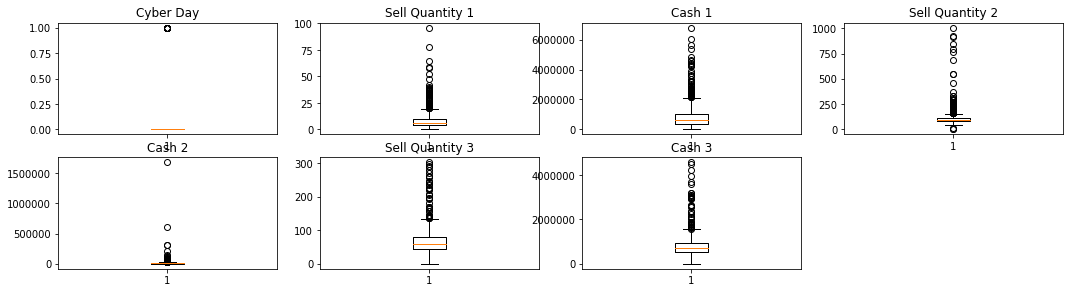

In [0]:
columns_names = df.columns.values

plt.figure(figsize=(18, 7))

for i in range(len(columns_names)):

  plt.subplot(3, 4, i+1)
  plt.boxplot(df[columns_names[i]].values)
  plt.title(columns_names[i])

plt.show()

Se separan los conjuntos entre datos para entrenamiento y datos para validación.

In [0]:
trainData = df[:500] #Apoximadamente el 70% de los datos serán para train
testData = df[500:635] #Apoximadamente el 18% de los datos serán para test
valData = df[635:] #Apoximadamente el 12% de los datos serán para valid


print("Train Data : %d, 70%% from dataset"%len(trainData))
print("Test Data : %d, 18%% from dataset"%len(testData))
print("Val Data : %d, 12%% from dataset"%len(valData))

Train Data : 500, 70% from dataset
Test Data : 135, 18% from dataset
Val Data : 80, 12% from dataset


Se utiliza un standar scaler para estandarizar los datos. Para los datos que se van a predecir, se les saca la información de los cyber day.

In [0]:
scaler = StandardScaler()
scaler.fit(trainData)

predicted = trainData.copy()
predicted = predicted.drop(['Cyber Day'], axis=1)

scaler2 = StandardScaler()
scaler2.fit(predicted)

train_data_scaled = scaler.transform(trainData)
test_data_scaled = scaler.transform(testData)

Se define un lag de 3 timestamps, en caso de elegir más la tasa de aprendizaje es muy lenta.

In [0]:
lag = len(more_sell_product)
X_train, y_train = create_dataset(train_data_scaled, lag)
X_test, y_test = create_dataset(test_data_scaled, lag)

In [0]:
X_train.shape, X_test.shape

((467, 3, 7), (102, 3, 7))

# Modelos

## LSTM con una capa densa y función de pérdida de mínimos cuadrados

En el primer modelo se utiliza una capa LSTM y una capa densa, con una loss de mínimos cuadrados.

In [0]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=128, input_shape=(len(more_sell_product), X_train.shape[2]), activation='softmax',return_sequences=False,go_backwards=False)) #128
model_LSTM.add(Dense(6,activation='linear'))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam') #0.8
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 70,406
Trainable params: 70,406
Non-trainable params: 0
_________________________________________________________________


In [0]:
resume = model_LSTM.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

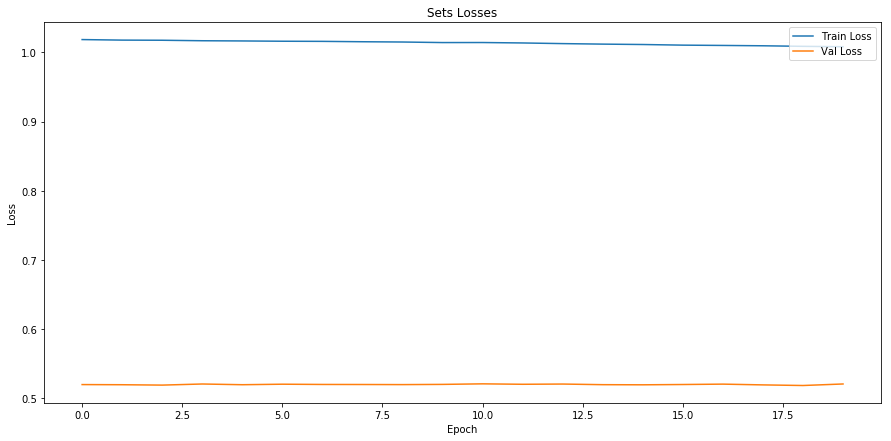

Final Train Loss: 1.0080991842379152
Val loss: 0.5185849704578811


In [0]:
plot_model_losses(resume)

Se puede notar que a medida que avanzan los epochs, la red no logra obtener un desempeño en aumento para el conjunto de pruebas.

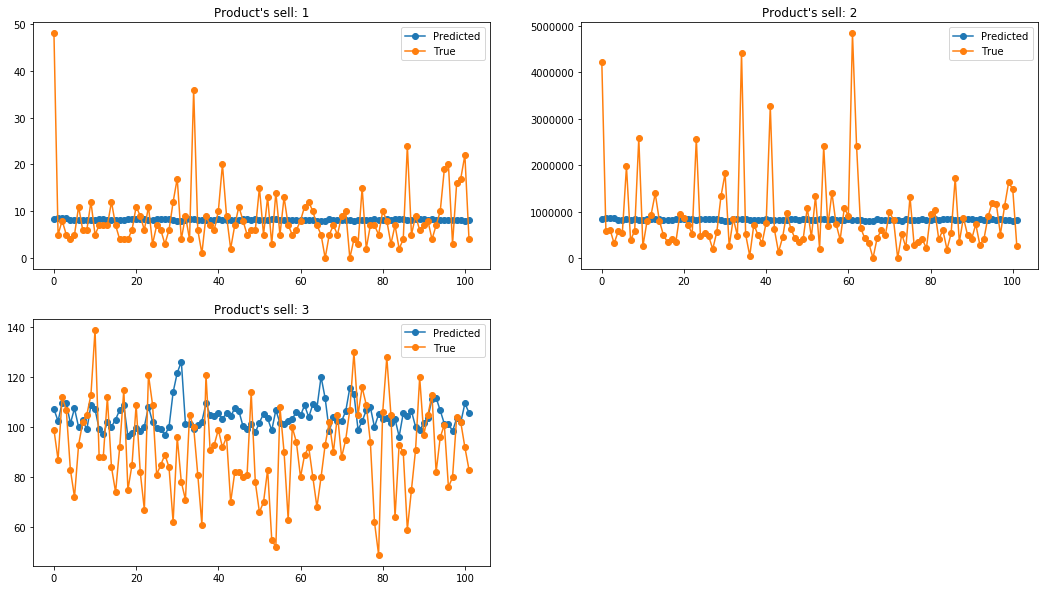

In [0]:
plot_predictions(model_LSTM, X_test, y_test)

Se puede ver que el modelo no es capaz de predecir los valores de la venta de los productos, el que más se acerca es el producto 3 con un RMSE de 22.

In [0]:
rmses_LSTM = rmse_f(model_LSTM, X_test, y_test, "LSTM")

Model LSTM:
RMSE product 1: 6
RMSE product 2: 862728
RMSE product 3: 22
RMSE global:    36158.32992294783


## LSTM con una capa densa y función de pérdida pinball

Se cambia la función de pérdida a pinball por los resultados anteriormente obtenidos para ver si mejora el modelo mejora.

In [0]:
model_LSTM_P = Sequential()
model_LSTM_P.add(LSTM(units=128, input_shape=(len(more_sell_product), X_train.shape[2]), activation='softmax',return_sequences=False,go_backwards=False)) #128
model_LSTM_P.add(Dense(6,activation='linear'))
model_LSTM_P.compile(loss=pinball(0.8), optimizer='adam') #0.8
model_LSTM_P.summary()
resume = model_LSTM_P.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 70,406
Trainable params: 70,406
Non-trainable params: 0
_________________________________________________________________


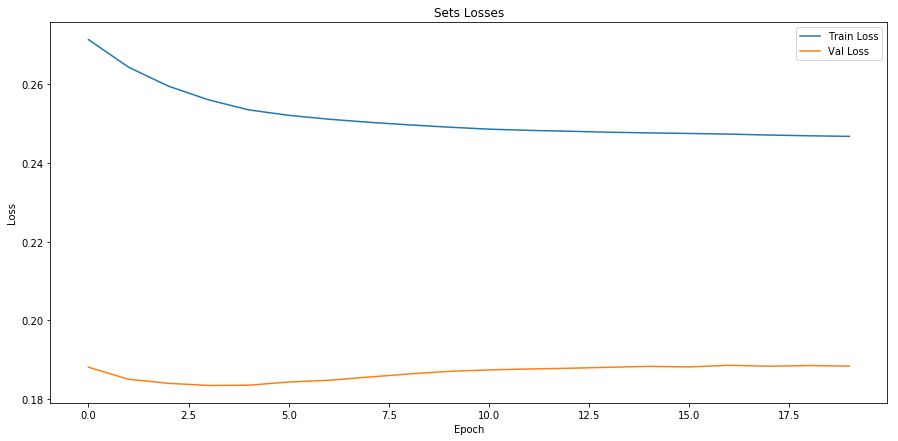

Final Train Loss: 0.2467786732111804
Val loss: 0.1834275983273983


In [0]:
plot_model_losses(resume)

Se ve una clara diferencia en cuanto a los valores de pérdida en ambos sets, bajando de 1 a 0.26 aproximadamente en el conjunto de entrenamiento y de 0.5 a 0.19 en el conjunto de validación.

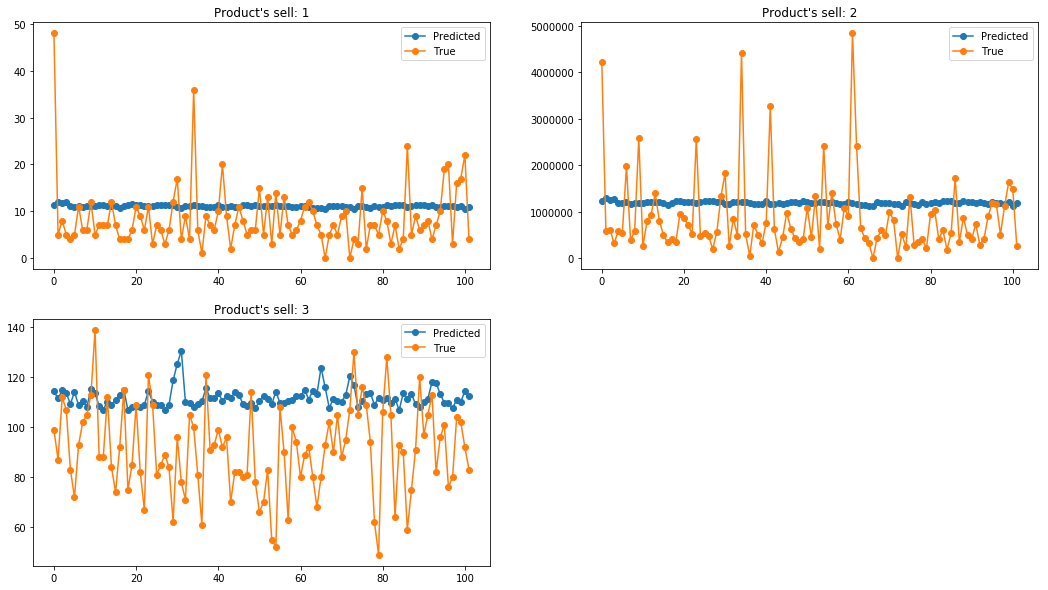

In [0]:
plot_predictions(model_LSTM_P, X_test, y_test)

El modelo sigue incapaz de predecir con exactitud o con alguna aproximación buena, pero mejora en cuanto al modelo anterior con función de perdida de mínimos cuadrados.

In [0]:
rmses_LSTM_P = rmse_f(model_LSTM_P, X_test, y_test, "LSTM P")

Model LSTM P:
RMSE product 1: 7
RMSE product 2: 920013
RMSE product 3: 27
RMSE global:    36078.72371319004


## LSTM con dos capas densas y una activación softmax, con función de pérdida squared hinge

Se agrega una capa densa con activación relu antes de la capa de salida y se cambia la función de pérdida de $squared$ $hinge$.

In [0]:
model_LSTM_D = Sequential()
model_LSTM_D.add(LSTM(units=128, input_shape=(len(more_sell_product), X_train.shape[2]), activation='tanh', return_sequences=False))
model_LSTM_D.add(Dense(64, activation='softmax'))
model_LSTM_D.add(Dense(units=6, activation='linear'))
model_LSTM_D.compile(loss='squared_hinge', optimizer='adam')
model_LSTM_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 78,278
Trainable params: 78,278
Non-trainable params: 0
_________________________________________________________________


In [0]:
resume = model_LSTM_D.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

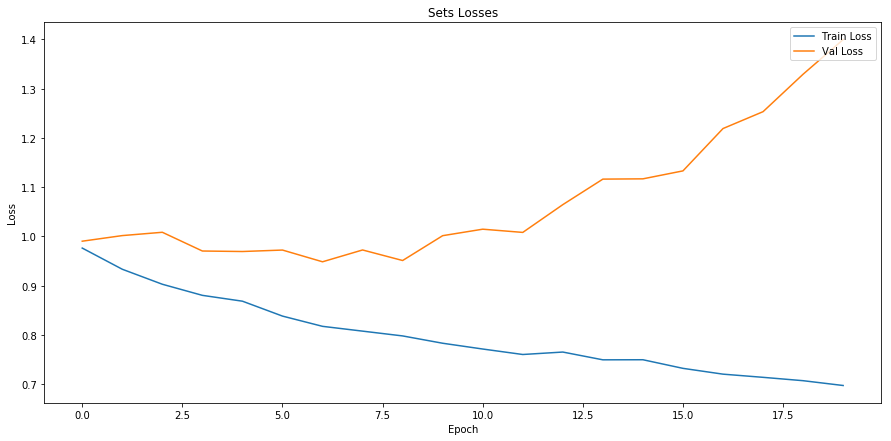

Final Train Loss: 0.6970954919014549
Val loss: 0.9484049157769072


In [0]:
plot_model_losses(resume)

El resultado obtenido es peor que en el módelo anterior, por lo que se probará nuevamente con la función de pérdida pinball.

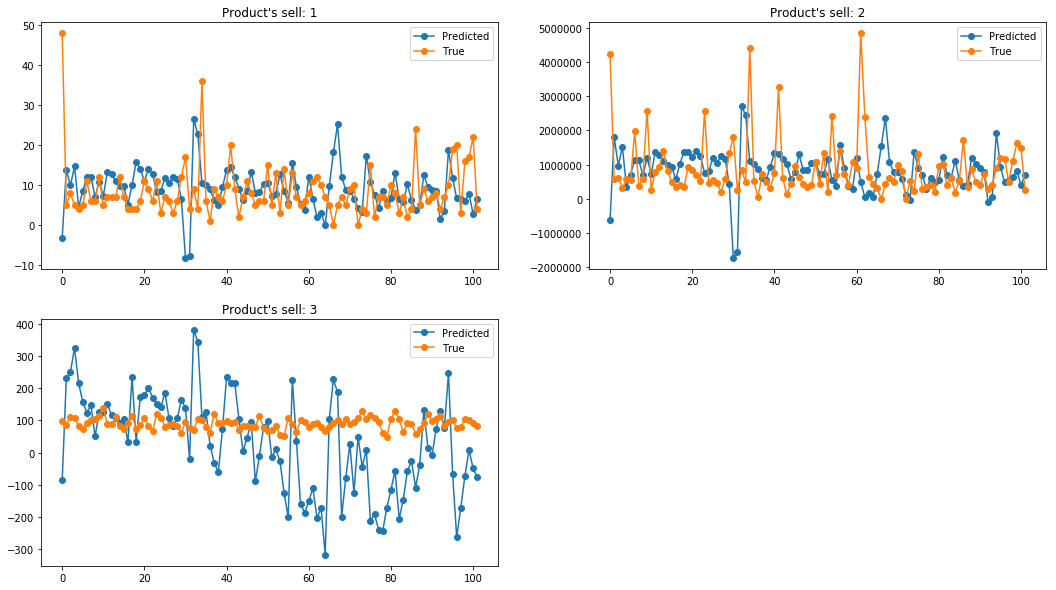

In [0]:
plot_predictions(model_LSTM_D, X_test, y_test)

Para este caso, se logra notar que por lo menos el tercer cuadro logra mejorar la predicción en comparación al modelo anterior, cabe destacar que la fecha que se predice en ese punto corresponde a uno de los dias cyberdays, por lo que la red fue capaz de predecir un tanto mejor las ventas de dichas fechas.

In [0]:
rmses_LSTM_D_D = rmse_f(model_LSTM_D, X_test, y_test, "LSMT D")

Model LSMT D:
RMSE product 1: 9
RMSE product 2: 1125658
RMSE product 3: 159
RMSE global:    134604.34472166697


## LSTM  con dos capas densas y una activación softmax, con función de pérdida pinball

In [0]:
model_LSTM_D = Sequential()
model_LSTM_D.add(LSTM(units=128, input_shape=(len(more_sell_product), X_train.shape[2]), activation='tanh', return_sequences=False))
model_LSTM_D.add(Dense(64, activation='relu'))
model_LSTM_D.add(Dense(units=6, activation='linear'))
model_LSTM_D.compile(loss=pinball(0.8), optimizer='adam')
model_LSTM_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 390       
Total params: 78,278
Trainable params: 78,278
Non-trainable params: 0
_________________________________________________________________


In [0]:
resume = model_LSTM_D.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

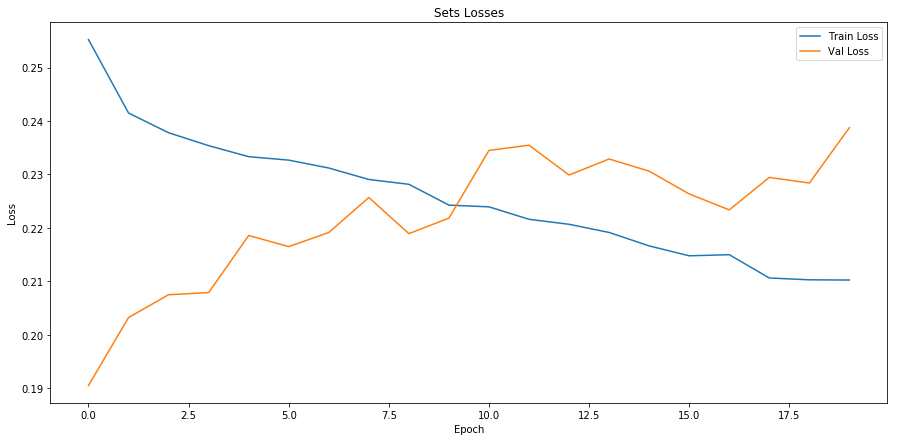

Final Train Loss: 0.21025734836718254
Val loss: 0.19053113014966833


In [0]:
plot_model_losses(resume)

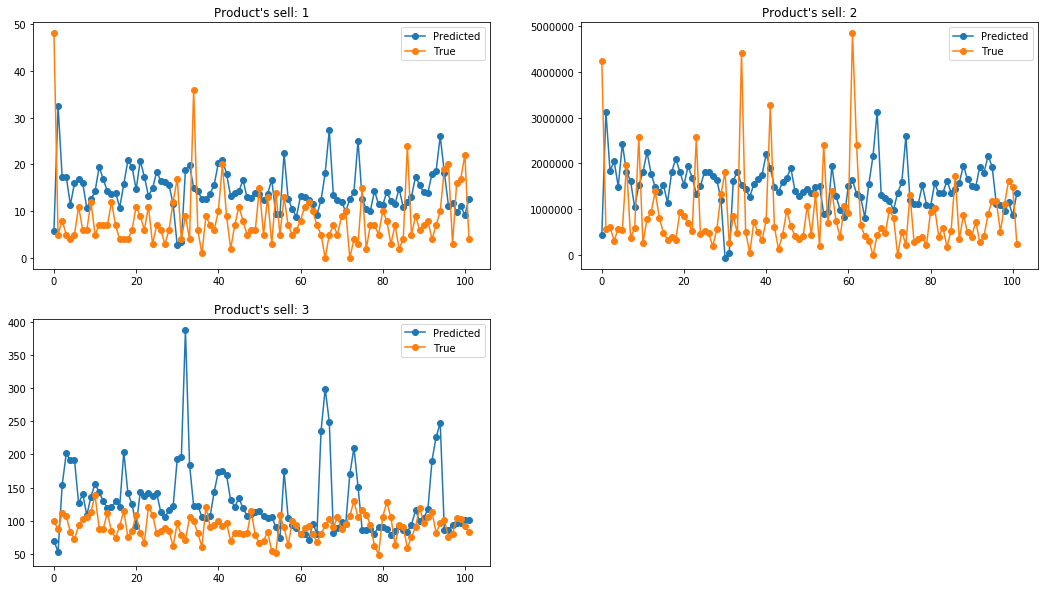

In [0]:
plot_predictions(model_LSTM_D, X_test, y_test)

In [0]:
rmses_LSTM_D_D = rmse_f(model_LSTM_D, X_test, y_test, "LSMT D")

Model LSMT D:
RMSE product 1: 10
RMSE product 2: 1237063
RMSE product 3: 65
RMSE global:    38101.836445094355


Se concluye a partir de los modelos entrenados anteriormente, que la función de pérdida pinball es la óptima para entrenar los modelos siguientes

## Convolucional 1D con una capa LSTM copn ativcación tangente hiperbóilca y una capa densa

In [0]:
model_C = Sequential()
model_C.add(Conv1D(32, kernel_size=2, input_shape=(lag, X_train.shape[2]), activation='relu', padding='valid')) # or kernel=2
model_C.add(LSTM(units=128, activation='tanh', return_sequences=False))
model_C.add(Dense(6, activation='linear'))
model_C.compile(loss=pinball(0.85), optimizer='adam')
model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 32)             480       
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 774       
Total params: 83,686
Trainable params: 83,686
Non-trainable params: 0
_________________________________________________________________


In [0]:
resume = model_C.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

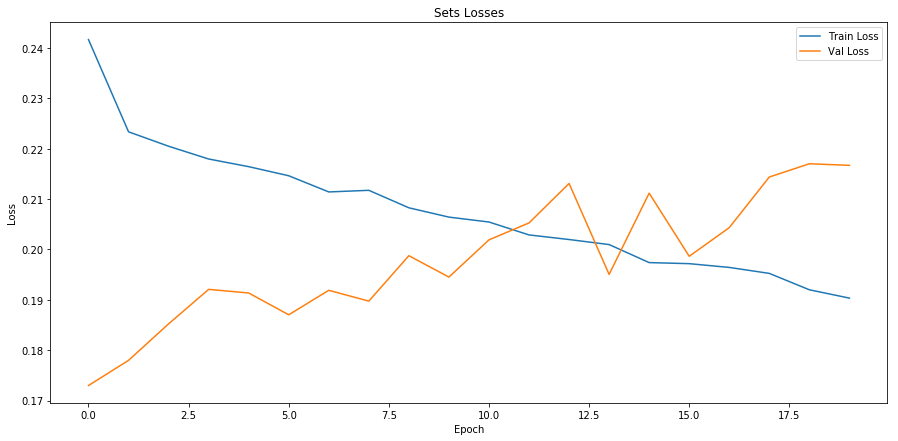

Final Train Loss: 0.19032564614071837
Val loss: 0.1729780968789961


In [0]:
plot_model_losses(resume)

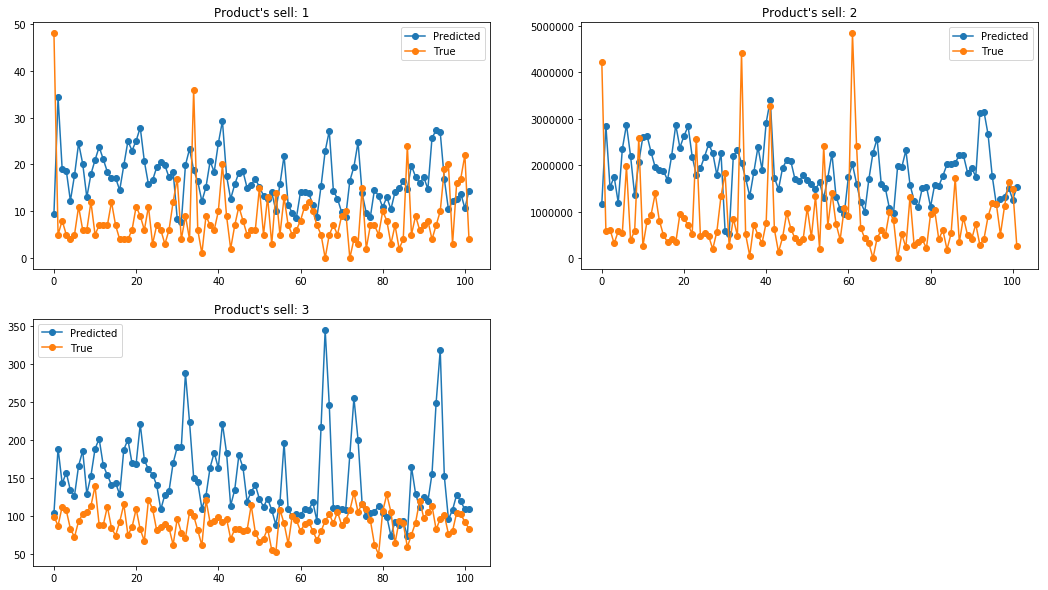

In [0]:
plot_predictions(model_C, X_test, y_test)

Ninguno de los modelos anteriormente entrenados ha hecho alguna aproximación óptima. El mejor resultado hasta el momento lo obtuvo el modelo LSTM con una capa densa y función de perdida pinball, con un val loss: 0.1834275983273983

In [0]:
rmses_C_LSTM = rmse_f(model_C, X_test, y_test, "Convolutional LSTM")

Model Convolutional LSTM:
RMSE product 1: 12
RMSE product 2: 1428263
RMSE product 3: 75
RMSE global:    36307.22170551032


## Convolucional 1D, LSTM y BatchNormalization

In [0]:
model_C_LSTM_B = Sequential()
model_C_LSTM_B.add(Conv1D(32, kernel_size=2, input_shape=(lag, X_train.shape[2]), activation='relu', padding='valid')) # or kernel=2
model_C_LSTM_B.add(LSTM(units=16, activation='tanh', return_sequences=False))
model_C_LSTM_B.add(BatchNormalization()) 
model_C_LSTM_B.add(Dense(6,activation='linear'))
model_C_LSTM_B.compile(loss=pinball(0.7), optimizer='adam')
model_C_LSTM_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2, 32)             480       
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 102       
Total params: 3,782
Trainable params: 3,750
Non-trainable params: 32
_________________________________________________________________


In [0]:
resume = model_C_LSTM_B.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

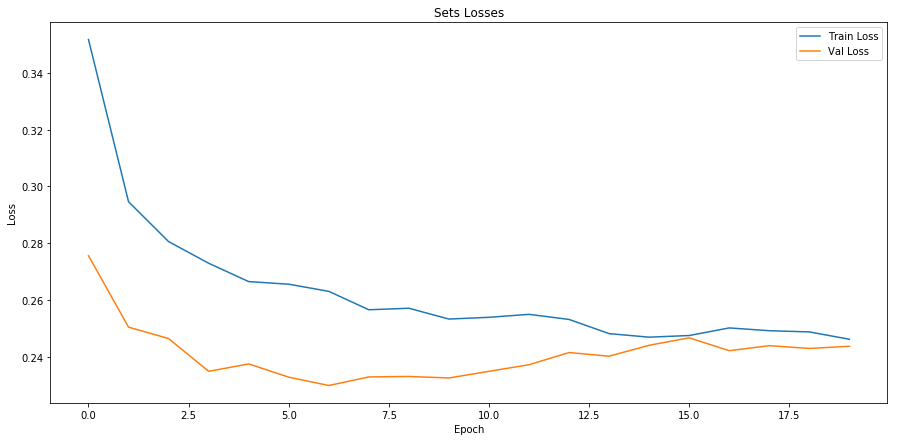

Final Train Loss: 0.2461129173444987
Val loss: 0.2298041430904585


In [0]:
plot_model_losses(resume)

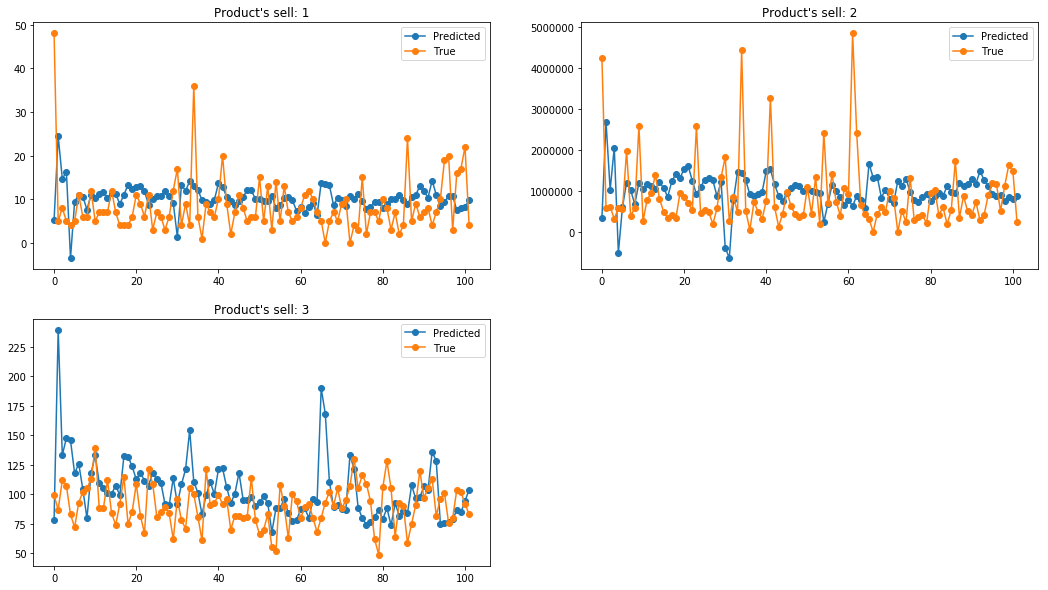

In [0]:
plot_predictions(model_C_LSTM_B, X_test, y_test)

In [0]:
rmses_C_LSTM_B = rmse_f(model_C_LSTM_B, X_test, y_test, "Convolutional LSTM B")

Model Convolutional LSTM B:
RMSE product 1: 8
RMSE product 2: 1015139
RMSE product 3: 31
RMSE global:    37731.29169133596


## Convolucional con Flatten

In [0]:
model_C_F = Sequential()
model_C_F.add(Conv1D(32, kernel_size=1, input_shape=(lag, X_train.shape[2]), activation='relu',padding='valid')) 
model_C_F.add(Flatten())
model_C_F.add(Dense(6,activation='linear'))
model_C_F.compile(loss=pinball(0.85), optimizer='adam')
model_C_F.summary()
cnn_weights = model_C_F.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 3, 32)             256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 582       
Total params: 838
Trainable params: 838
Non-trainable params: 0
_________________________________________________________________


In [0]:
resume = model_C_F.fit(X_train, y_train, epochs=20, batch_size=5, verbose=0, validation_data=(X_test, y_test))

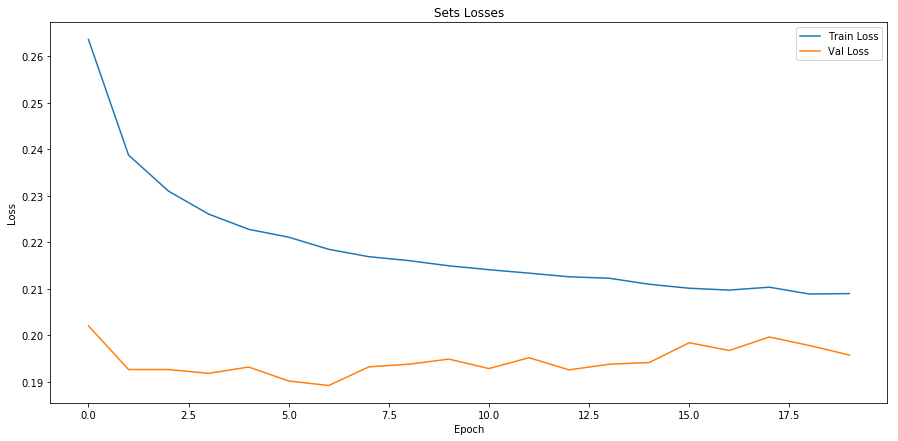

Final Train Loss: 0.20897850033685533
Val loss: 0.189217313612793


In [0]:
plot_model_losses(resume)

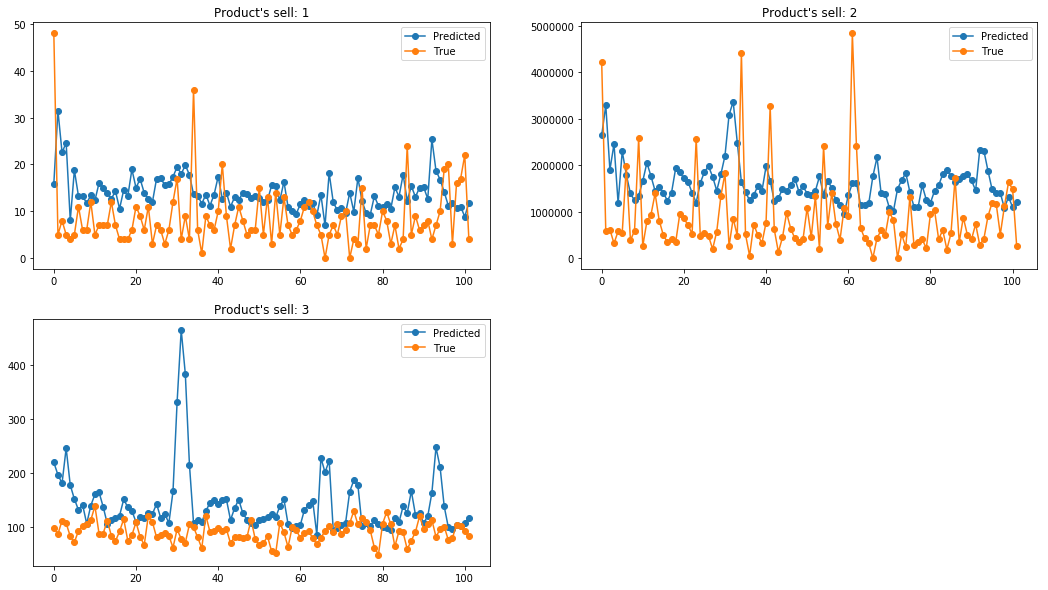

In [0]:
plot_predictions(model_C_F, X_test, y_test)

In [0]:
rmses_C_F = rmse_f(model_C_F, X_test, y_test, "Convolutional Flatten")

Model Convolutional Flatten:
RMSE product 1: 9
RMSE product 2: 1215542
RMSE product 3: 78
RMSE global:    38937.53440132451


In [0]:
print("RMSE Finales:")
print("RMSE modelo 1:",rmses_LSTM[3])
print("RMSE modelo 2:",rmses_LSTM_D_D[3])
print("RMSE modelo 3:",rmses_C_LSTM[3])
print("RMSE modelo 4:",rmses_C_LSTM_B[3])
print("RMSE modelo F:",rmses_C_F[3])

RMSE Finales:
RMSE modelo 1: 36158.32992294783
RMSE modelo 2: 38101.836445094355
RMSE modelo 3: 36307.22170551032
RMSE modelo 4: 37731.29169133596
RMSE modelo F: 38937.53440132451


Se puede haber creado el data set sin las columnas del dinero recolectado, se pensó que esto le daría información a los modelos a la hora de entrenar, por este motivo, se dejaron las columnas y se crearon los dataset.